**ANNs for loan prediction**

1. Loading the Dataset

**1.1 Import the necessary Python modules**

In [2]:
import numpy as np # numpy is a library that allows us to work with vectors and matrices
import matplotlib.pyplot as plt # visualisation library
import pandas as pd # pandas is a library that allows us to work with DataFrames


In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [4]:
from IPython.display import HTML
def pretty_print_df(value_counts_):
  """
    Quick function to display value counts more nicely.
    It is only helpful in notebook. If working on .py script, just replace
    with 'print'
  """
  display(HTML(pd.DataFrame(value_counts_).to_html()))

Load the data

In [5]:
PY = False # change this to True if you're running the .py version of this notebook
if not PY:
    from google.colab import drive
    import os
    drive.mount('/content/drive')
    # note: the lines below assume that the data is found in the main folder of your google drive.
    # If that's not the case, you need to change the argument of read_csv to the full
    # path of each dataset
    X = pd.read_csv('/content/drive/MyDrive/Greenwich /Machine Learning/Lab 7 /Week 7 tutorials solutions comp1804/Comp1804_week7_dataset_22-23/X_train.csv')
    Y = pd.read_csv('//content/drive/MyDrive/Greenwich /Machine Learning/Lab 7 /Week 7 tutorials solutions comp1804/Comp1804_week7_dataset_22-23/Y_train.csv')
else:
    # note: the lines below assume that the data is found in the same folder as this notebook.
    # If that's not the case, you need to change the argument of read_csv to the full
    # path of each dataset
    X = pd.read_csv('/content/drive/MyDrive/Greenwich /Machine Learning/Lab 7 /Week 7 tutorials solutions comp1804/Comp1804_week7_dataset_22-23/X_train.csv')
    Y = pd.read_csv('/content/drive/MyDrive/Greenwich /Machine Learning/Lab 7 /Week 7 tutorials solutions comp1804/Comp1804_week7_dataset_22-23/Y_train.csv')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1.2.0 Dataset Split**

Let's split both the input features and the labels into a training set and a test set. Scikit-learn has a helpful function for this: "train_test_split".


In [6]:
from sklearn.model_selection import train_test_split


train_dataset, test_dataset, train_labels, test_labels = train_test_split(X, Y,
                                                                          stratify = Y, #we use a stratified division to make sure we keep the same proportion of target labels in both the training and the test dataset (see data imbalance below)
                                                                          test_size= 0.2)


**1.2.1 Inspect Dataset**

**1.2.1.1 Dimensions of Dataset**


In [7]:
# Training data
# shape of input:
# The number or rows is the number of data points
# The number or columns is the number of features
print(train_dataset.shape)
# shape of output:
# The number or rows is the number of data points (should be the same as before!)
# The number or columns is the number of labels we want to predict
print(train_labels.shape)

(312, 12)
(312, 1)


In [8]:
# Test data
# shape of input:
# The number or rows is the number of data points
# The number or columns is the number of features (should be the same as for the training!)
print(test_dataset.shape)
# shape of output:
# The number or rows is the number of data points (should be the same as before!)
# The number or columns is the number of labels we want to predict
print(test_labels.shape)

(79, 12)
(79, 1)


In [9]:
# list of column titles
print(train_dataset.columns)
print(train_labels.columns)

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')
Index(['Target'], dtype='object')


In [10]:
# list of column (field) data types
print(train_dataset.dtypes)
print()
print(train_labels.dtypes)

# Note: object is a Pandas data type for pretty much anything that is not a number

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome      float64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
dtype: object

Target    object
dtype: object


**1.2.1.2 Take a peek at the Dataset**

Note that if you see "NaN", it means "Not a Number". It is not the same as 0. Python replaces empty/missing fields in the data with "NaN".


In [11]:
# you can show the first N rows in a dataframe with the function "head"
print(train_dataset.head(10))
# note how the first row has a missing value! We'll get back to it.
# Also notice how the first two rows are almost identical, aside from the Loan_ID and the missing value
# Could this be the same application submitted twice because the first time someone forgot to add the income?

      Loan_ID  Gender Married Dependents     Education Self_Employed  \
319  LP002364    Male     Yes          0      Graduate            No   
279  LP002948    Male     Yes          2      Graduate            No   
349  LP002407  Female     Yes          0  Not Graduate           Yes   
343  LP001698    Male      No          0  Not Graduate            No   
93   LP001493    Male     Yes          2  Not Graduate            No   
17   LP002789    Male     Yes          0      Graduate            No   
313  LP001963    Male     Yes          1      Graduate            No   
90   LP001199    Male     Yes          2  Not Graduate            No   
249  LP002328    Male     Yes          0  Not Graduate            No   
76   LP002840  Female      No          0      Graduate            No   

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
319          14880.0                0.0        96.0             360.0   
279           5780.0                0.0       192.0          

In [12]:
# Let's print the percentage or target categories in both the training and test dataset
# printing the percentage means we can compare whether the two label distributions are similar
print('Label distribution in training dataset')
print(train_labels.value_counts(normalize=True))

print('Label distribution in test dataset')
print(test_labels.value_counts(normalize=True))


Label distribution in training dataset
Target
Y         0.705128
N         0.294872
dtype: float64
Label distribution in test dataset
Target
Y         0.708861
N         0.291139
dtype: float64


## 2. Data cleaning

(If you want to check again the EDA steps, check the notebook from week 2.)


In [13]:
# Data cleaning steps:
# 1. replace 'yes' with 'Yes' for 'self_employed'
# remember that .loc is a way to access a subset of the dataframe
# We can write df.loc[condition_A, condition_B] where condition_A determines
# which rows we select and condition_B determines which columns we select
train_dataset.loc[train_dataset.Self_Employed=='no','Self_Employed'] = 'No'
test_dataset.loc[test_dataset.Self_Employed=='no','Self_Employed'] = 'No'

# 2. replace negative loan amount values with NaN
# (we use np.nan because that's how the other missing values are represented in this dataset)
train_dataset.loc[train_dataset.LoanAmount<0,'LoanAmount'] = np.nan
test_dataset.loc[test_dataset.LoanAmount<0,'LoanAmount'] = np.nan

# 3. replace out of scope Property_Area values with NaN
accepted_property_areas = ['Urban','Rural','Semiurban']
# remember the lambda notation: it is an anonymous function that lets us specificy
# a given (and easy) transformation for its input (in this case, x)
train_dataset.loc[train_dataset.Property_Area.map(lambda x: x not in accepted_property_areas),'Property_Area'] = np.nan
test_dataset.loc[test_dataset.Property_Area.map(lambda x: x not in accepted_property_areas),'Property_Area'] = np.nan


In [14]:
from sklearn.preprocessing import LabelEncoder

# create an object of the LabelEncoder class
lblEncoder_Y = LabelEncoder()

# apply LblEncoder object to our target variables
train_encoded_labels = lblEncoder_Y.fit_transform(train_labels['Target'])
print(train_encoded_labels)

# apply label encoder to test data
test_encoded_labels = lblEncoder_Y.transform(test_labels['Target'])


[1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 1 1 0 0 0 1 0 0 1 0 0 0 1 1 1 0 1
 1 0 0 1 0 1 0 1 0 0 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 0 0 1 1 0 1 1 0 1 0 1 0 1 1 1 1
 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 1 0 1
 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1
 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1
 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1
 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0
 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1]


Scikit-learn pipeline

In [15]:
train_dataset.isna().sum()

Loan_ID              0
Gender               0
Married              1
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      2
CoapplicantIncome    1
LoanAmount           3
Loan_Amount_Term     1
Credit_History       1
Property_Area        3
dtype: int64

In [16]:
# split the columns into the right type
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome',
                'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

categorical_columns= ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area']


Applying pipelines with Column Transformer.

First, note that in this case we want to process numerical and categorical columns in two completely different ways. Specifically:

For numerical columns, we want to impute missing values using the median and then normalize the data to have 0 mean and unit standard deviation.
For categorical columns, we want to impute missing values using the most common category and then encode using One Hot Encoding.
These are basically two parallel pipelines applied to disjoint sets of columns.

So, we can define each pipeline separately and then apply it to the correct subset of columns!

Note the difference from week 3: we're doing everything with way fewer lines of code while still keeping all the flexibility as before!

In [17]:
# Create the two pipelines

# Numerical Features
# concatenate missing value imputation and standardization for numerical features
numeric_transformer = Pipeline(
    steps=[("num_imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler()),
           ]
)

# Categorical Features
# concatenate missing value imputation and onehot encoding for categorical features
categorical_transformer = Pipeline(
    steps=[
        ('cat_imputer', SimpleImputer(strategy='most_frequent')),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# ColumnTransformer takes a list of transformations. Each transformation is expressed
# as a tuple (name, transformer, columns).
# We transform categorical columns and numerical columns using the two different pipelines we defined above
preprocessor = ColumnTransformer(
    transformers=[
        ("num", # --> name of the transformation
         numeric_transformer, # --> main function to apply
         numerical_columns  #-->columns to apply it to (we can give more than one column at once!)
         ),
        ("cat", categorical_transformer, categorical_columns),
    ],
    remainder = "passthrough",
    verbose_feature_names_out=False,
)



In [18]:
# Let's put all together into a pipeline, adding the classifier as well
preprocess_ = Pipeline(
        steps=[("preprocessor", preprocessor),
               #('ann', ANN())
        ]
    )

In [19]:
# Fit and apply preprocessing pipeline
# NOTE: we don't want to use the Loan ID though, since it's just an identifier for each
# row, it doesn't carry any information about the output
preprocessor.fit(train_dataset.drop(columns=['Loan_ID']))
# training data
X_train_preprocessed = preprocessor.transform(train_dataset.drop(columns=['Loan_ID']))
# testing data
X_test_preprocessed= preprocessor.transform(test_dataset.drop(columns=['Loan_ID']))


In [20]:
print(train_dataset.shape)
print(X_train_preprocessed.shape)

(312, 12)
(312, 21)


In [21]:
X_train_preprocessed[0, :]

array([ 1.70654585, -0.60285306, -0.60738702,  0.28003072,  0.42113951,
        0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        0.        ])

In [22]:
print(preprocessor.transformers_[1][1]['encoder'].get_feature_names_out())

print(preprocessor.transformers_[0][1]['scaler'].get_feature_names_out())


['x0_Female' 'x0_Male' 'x0_other' 'x1_No' 'x1_Yes' 'x2_0' 'x2_1' 'x2_2'
 'x2_3+' 'x3_Graduate' 'x3_Not Graduate' 'x4_No' 'x4_Yes' 'x5_Rural'
 'x5_Semiurban' 'x5_Urban']
['x0' 'x1' 'x2' 'x3' 'x4']


Modelling

Build ANN

In [23]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# create a simple model with ONE hidden layer only
model = models.Sequential()
# we will create a hidden layer with 20 nodes.
hidden_layer_nodes = 20
num_of_input_features = X_train_preprocessed.shape[1] #number of features = number of columns in the input matrix

# We can specify an input layer to tell Keras what input to expect.
# we tell Keras how many features to expect for each datapoint. This way Keras
# knows how many weights are needed between the input and the first hidden layer
model.add(layers.Input(shape=(num_of_input_features,)))
model.add(layers.Dense(hidden_layer_nodes, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) #is it clear why here we use "sigmoid" and use "softmax" for multi-class problems?

# as metric we choose the accuracy: the total number of correct predictions made
# Adam is a typical choice for an optimizer and tends to perform well in practice
# the most typical choice for the loss function is the binary cross entropy since
# we are solving a binary classification task. If we were solving a multi-class classification
# task, we'd choose the categorical cross entropy (that is, the more general version)
learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(), #we use this function for BINARY CLASSIFICATION
              metrics=['accuracy'])

# let's print a summary of the model to see what it's like
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                440       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________
None


Data imbalance

In [24]:
# compute class weights to counteract data imbalance
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight= "balanced",
    classes = np.unique(train_encoded_labels),
    y = train_encoded_labels)

# we turn the weights into a dictionary
class_weights = dict(zip(np.unique(train_encoded_labels), class_weights))

# Let's print the results
# note that encoded label 0 corresponds to the original label 'N': there are fewer instances of 'N' so this class is given a higher weight in the loss function
print(class_weights)


{0: 1.6956521739130435, 1: 0.7090909090909091}


Model training

In [25]:
# Training
# let's define some relevant hyper-parameters:
batch_size = 130 # The batch size indicates how many data points we use to compute each update to the parameters of the models (based on the gradient of the loss)
epochs = 50 #how long we train the model for
validation_split = 0.2  #Fraction of the training data to be used as validation data.
history = model.fit(X_train_preprocessed,
                    train_encoded_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split= validation_split,
                    class_weight= class_weights,
                    )
# note that the output variable "history" keeps track of the model performance at each epoch


Epoch 1/50
2/2 [==============================] - 3s 887ms/step - loss: 0.9281 - accuracy: 0.6787 - val_loss: 0.5957 - val_accuracy: 0.7778
Epoch 2/50
2/2 [==============================] - 0s 106ms/step - loss: 0.9122 - accuracy: 0.6747 - val_loss: 0.5968 - val_accuracy: 0.7778
Epoch 3/50
2/2 [==============================] - 0s 171ms/step - loss: 0.8975 - accuracy: 0.6747 - val_loss: 0.5982 - val_accuracy: 0.7778
Epoch 4/50
2/2 [==============================] - 0s 69ms/step - loss: 0.8841 - accuracy: 0.6707 - val_loss: 0.5996 - val_accuracy: 0.7619
Epoch 5/50
2/2 [==============================] - 0s 95ms/step - loss: 0.8712 - accuracy: 0.6707 - val_loss: 0.6012 - val_accuracy: 0.7619
Epoch 6/50
2/2 [==============================] - 0s 63ms/step - loss: 0.8582 - accuracy: 0.6586 - val_loss: 0.6030 - val_accuracy: 0.7619
Epoch 7/50
2/2 [==============================] - 0s 64ms/step - loss: 0.8453 - accuracy: 0.6667 - val_loss: 0.6050 - val_accuracy: 0.7460
Epoch 8/50
2/2 [========

### Evaluation

We can see if and how the network improved during training, using the performance metrics on both the training and the validation data.

In [26]:
# let's see what's within the 'history' variable
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

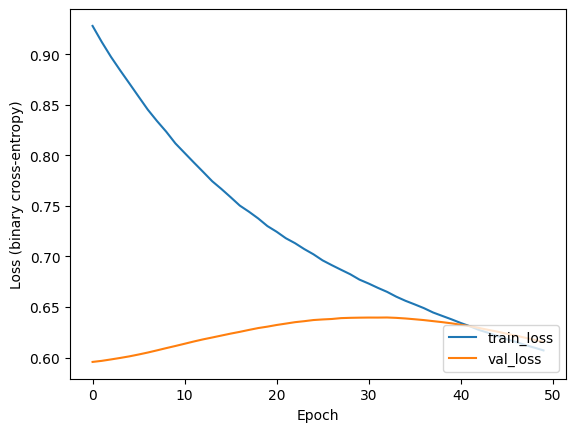

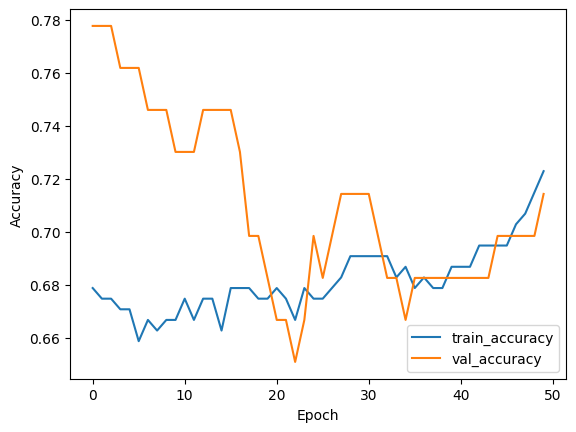

In [27]:
# Plot training curves for both training and validation data
# loss per epoch
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (binary cross-entropy)')
plt.legend(loc='lower right')

#accuracy per epoch
plt.figure()
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


Then, we can compute the prediction and the final metrics on the test dataset.

3/3 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           N       0.43      0.52      0.47        23
           Y       0.78      0.71      0.75        56

    accuracy                           0.66        79
   macro avg       0.61      0.62      0.61        79
weighted avg       0.68      0.66      0.67        79

The balanced accuracy score is 0.618



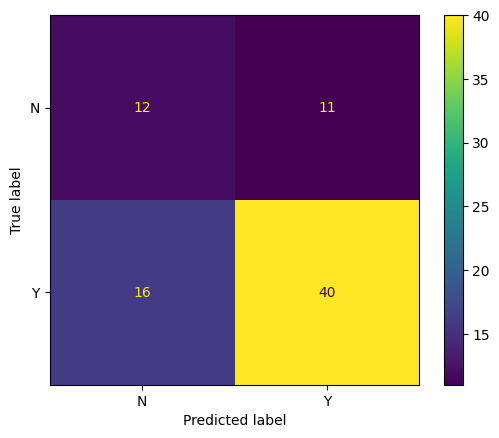

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import balanced_accuracy_score

# Check performance on test data
test_probabilities = model.predict(X_test_preprocessed)
# There is a small difference from scikit-learn when we call .predict()
# Keras returns the *class probabilities* rather than the predictions
# For a binary classification problem, this is the probability that a data point
# belongs to class 1.
# So, to get the class we apply a threshold of 0.5: if the probability of being in
# class 1 is higher than 0.5 we assign that data point to class 1, otherwise to
# class 0. This is done by the following line:
test_predictions = test_probabilities > .5

# let's show the classification report with all the metrics
# think about which metrics you think are the most important ones for this problem!
print(classification_report(test_encoded_labels,test_predictions,
                            target_names= lblEncoder_Y.classes_)) # this is to give the real categories, not their encoded numbers

# let's also print the balanced accuracy score, since we know the dataset is not balanced
print(f'The balanced accuracy score is {balanced_accuracy_score(test_encoded_labels,test_predictions):.3f}\n')

# let's get all the numbers for the confusion matrix
cm = confusion_matrix(test_encoded_labels,test_predictions)#,
#                      labels= lblEncoder_Y.classes_) # this is to give the real categories, not their encoded numbers

# let's show the confusion matrix in a plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels= lblEncoder_Y.classes_) # this is to give the real categories, not their encoded numbers
disp.plot()
plt.show()


In [29]:
model = models.Sequential()
hidden_layer_nodes = 20
num_of_input_features = X_train_preprocessed.shape[1]
dropout_rate= 0.2 #0.2 is usually a good number to start with

model.add(layers.Dense(hidden_layer_nodes, input_dim=num_of_input_features, activation='relu'))
model.add(layers.Dropout(rate=dropout_rate)
model.add(layers.Dense(1, activation='sigmoid'))

SyntaxError: ignored

In [31]:
### YOUR CODE HERE (OR MODIFY ABOVE) ####
from sklearn.metrics import accuracy_score
model = models.Sequential()
hidden_layer_nodes = 20
num_of_input_features = X_train_preprocessed.shape[1]
dropout_rate= 0.2 #0.2 is usually a good number to start with

model.add(layers.Dense(hidden_layer_nodes, input_dim=num_of_input_features, activation='relu'))
model.add(layers.Dropout(rate=dropout_rate)
model.add(layers.Dense(1, activation='sigmoid'))
# For example, let's compute and visualize how the accuracy changes with different learning rates

# First, recreate the model.
# We'll wrap the different stages into a function, since then it's easier to play with the parameters

def create_model_single_hidden(n_hidden=20, num_of_input_features= X_train_preprocessed.shape[1]):
    model = models.Sequential()
    model.add(layers.Input(shape=(num_of_input_features,))
    model.add(layers.Dense(n_hidden, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

def model_compile_and_training(model, X_train_preprocessed, train_encoded_labels, #test_dataset_no_nans, test_encoded_labels,
                               optimizer_name = 'Adam', learning_rate= 0.001,
                               n_epochs= 50, batch_size=256,
                               validation_split= 0.2):
    if optimizer_name== 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate)

    # as metric we choose the accuracy: the total number of correct predictions made
    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

    #print(model.summary())

    # Training
    validation_split = 0.2  #Fraction of the training data to be used as validation data.
    history = model.fit(X_train_preprocessed,
                    train_encoded_labels,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_split= validation_split,
                    verbose=0, #this avoids getting lots of output
                    )
    return model, history


l_rates = [0.00001, 0.0001, 0.001, 0.01, 0.05]
final_accuracies_train = []
final_accuracies_val = []
final_accuracies_test = []
for i, l_rate in enumerate(l_rates):
    model = create_model_single_hidden()

    model, history = model_compile_and_training(model, X_train_preprocessed, train_encoded_labels,
                               learning_rate= l_rate)

    final_accuracies_train.append(history.history['accuracy'][-1])
    final_accuracies_val.append(history.history['val_accuracy'][-1])
    # predict the test labels and save the accuracy score
    test_probabilities = model.predict(X_test_preprocessed)
    test_predictions = test_probabilities > .5
    final_accuracies_test.append(accuracy_score(test_encoded_labels,test_predictions))


SyntaxError: ignored